In [138]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import matplotlib.pyplot as plt

In [65]:
path = 'prelim_data_acs.csv'
lower_alpha_bound = 0
upper_alpha_bound = 100
alpha_iterations = 100
max_iters=1000

data = pd.read_csv(path, index_col=0)

In [81]:
def run_lasso_model(path, alpha_lower_bound=0, alpha_upper_bound=100, alpha_iterations=101, max_iterations=1000):
    '''
    Function to run the lasso regression model on our data for the capstone project.
    Need to enter in the path to the data, and then have optional arguments you can enter.
    
    Inputs:
    path - name of the data file, in quotes as a text string.
    alpha_lower_bound - lower end of the penalization hyperparameter for the lasso regression. Defaults to 0
    alpha_upper_bound - upper end of the penalization hyperparameter for the lasso regression. Defaults to 100
    alpha_iterations - number of values used in the previously specified range for alpha. Defaults to 101
    max_iterations - maximum iterations for the lasso regression. Defaults to 1,000.
    '''
    # Load the data
    data = pd.read_csv(path, index_col=0)
    
    # Find the y-value column
    for i in range(0,500):
        try:
            datetime.strptime(data.iloc[:,i].name, '%Y-%m')
            date_col_name = data.iloc[:,i].name
            break
        except:
            i+=1
            
    # Create X and y for machine learning
    X = data.drop([date_col_name, 'RegionName', 'City', 'State'], axis=1)
    y = data[date_col_name]
    
    # Create and fit the model
    lasso = Lasso(normalize=True, max_iter=max_iterations)
    lasso_params = {'alpha':np.linspace(alpha_lower_bound,alpha_upper_bound,alpha_iterations)}
    grid_lasso = GridSearchCV(lasso, lasso_params, scoring='r2', n_jobs=-1, cv=5, verbose=2)
    grid_lasso.fit(X, y)
    
    # Tell user alpha used
    print('Best alpha: ', grid_lasso.best_params_['alpha'])
    
    # Tell user training score
    print('Score on training data: ', round(grid_lasso.score(X,y),3))
    
    # Tell user the croo-validation scores
    print('Scores from 5-fold cross-validation: \n', cross_val_score(grid_lasso, X, y, scoring='r2', n_jobs=-1, cv=5))
    
    
    

In [82]:
run_lasso_model(path)

Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  1.0
Score on training data:  0.606
Scores from 5-fold cross-validation: 
 [0.83162625 0.82842924 0.85980755 0.28358486 0.80688221]


In [161]:
# Trying it with a scaler, so I can do multicollinearity analysis after.


def run_lasso_model_scaled(path, alpha_lower_bound=0, alpha_upper_bound=100, alpha_iterations=101, max_iterations=1000):
    '''
    Function to run the lasso regression model on our data for the capstone project.
    Need to enter in the path to the data, and then have optional arguments you can enter.
    
    Inputs:
    path - name of the data file, in quotes as a text string.
    alpha_lower_bound - lower end of the penalization hyperparameter for the lasso regression. Defaults to 0
    alpha_upper_bound - upper end of the penalization hyperparameter for the lasso regression. Defaults to 100
    alpha_iterations - number of values used in the previously specified range for alpha. Defaults to 101
    max_iterations - maximum iterations for the lasso regression. Defaults to 1,000.
    '''
    # Load the data
    data = pd.read_csv(path, index_col=0)
    
    # Find the y-value column
    for i in range(0,500):
        try:
            datetime.strptime(data.iloc[:,i].name, '%Y-%m')
            date_col_name = data.iloc[:,i].name
            break
        except:
            i+=1
            
    # Create X and y for machine learning
    X = data.drop([date_col_name, 'RegionName', 'City', 'State'], axis=1)
    y = data[date_col_name]
    
    ## SCALE DATA ## - MinMax or Standardization? or Normalizer? I am thinking standardization, less affected by outliers. 
    X_scaled = StandardScaler().fit_transform(X)
    
    
    # Create and fit the model
    lasso = Lasso(normalize=False, max_iter=max_iterations)
    lasso_params = {'alpha':np.linspace(alpha_lower_bound,alpha_upper_bound,alpha_iterations)}
    grid_lasso = GridSearchCV(lasso, lasso_params, scoring='r2', n_jobs=-1, cv=5, verbose=2)
    grid_lasso.fit(X_scaled, y)
    
    # Tell user alpha used
    print('Best alpha: ', grid_lasso.best_params_['alpha'])
    
    # Tell user training score
    print('Score on training data: ', round(grid_lasso.score(X_scaled,y),3))
    
    # Tell user the croo-validation scores
    #print('Scores from 5-fold cross-validation: \n', cross_val_score(grid_lasso, X_scaled, y, scoring='r2', n_jobs=-1, cv=5))
    
    # Get coefs for best model
    best_mod = Lasso(alpha=grid_lasso.best_params_['alpha'], max_iter = max_iterations)
    best_mod.fit(X_scaled, y)
    coef_list = list(zip(list(X.columns), best_mod.coef_))
    print('Total features: ', len(coef_list))
    used_list = []
    for x in coef_list:
        if x[1] != 0:
            used_list.append(x)
    print('Number of Features used: ', len(used_list), '\n')
    print('Used Features, sorted by importance:')
    for x in sorted(used_list, key=lambda x: abs(x[1]), reverse=True):
        print(x)
    
    # Return multicollinearity chart
    feature_names = [x[0] for x in used_list]
    RSquared = []
    variable_name = []
    for var in feature_names:
        dep_var = StandardScaler().fit_transform(np.array(X[var]).reshape(-1,1))
        predictors =StandardScaler().fit_transform(X.drop(var, axis=1))
        ols = LinearRegression()
        ols.fit(predictors, dep_var)
        variable_name.append(var)
        RSquared.append(ols.score(predictors, dep_var))

    val_dfs = pd.concat([pd.Series(RSquared), pd.Series(variable_name)], axis=1)
    val_dfs = val_dfs.sort_values(by=0, ascending=False)
    
    ## Plotting multicollinearity test from previous project ##
    plt.plot(val_dfs[1], val_dfs[0])
    plt.xticks(rotation=90)
    plt.ylim(0.5,1)
    plt.rcParams["figure.figsize"] = (30,3)
    plt.show()
    

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best alpha:  8.0
Score on training data:  0.66
Total features:  228
Number of Features used:  53 

Used Features, sorted by importance:
('median_rent', 316.26694831435316)
('owner_occupied_housing_units_lower_value_quartile', 184.1264194574003)
('owner_occupied_housing_units_upper_value_quartile', 107.299873924778)
('rent_under_10_percent', 83.20770752402845)
('male_45_64_graduate_degree', -73.845637421888)
('income_per_capita', -61.04471920503612)
('different_house_year_ago_same_city', -51.03801463808566)
('male_45_64_less_than_9_grade', 46.964152248697424)
('percent_income_spent_on_rent', 43.05029306052354)
('income_25000_29999', -39.11124147684708)
('million_dollar_housing_units', -35.990815986449114)
('rent_30_to_35_percent', 33.42731134167269)
('income_50000_59999', -29.926599199637423)
('walked_to_work', 29.86440999057707)
('male_male_households', 28.07197607775121)
('vacant_housing_units_for_rent', -27.755713457881015)

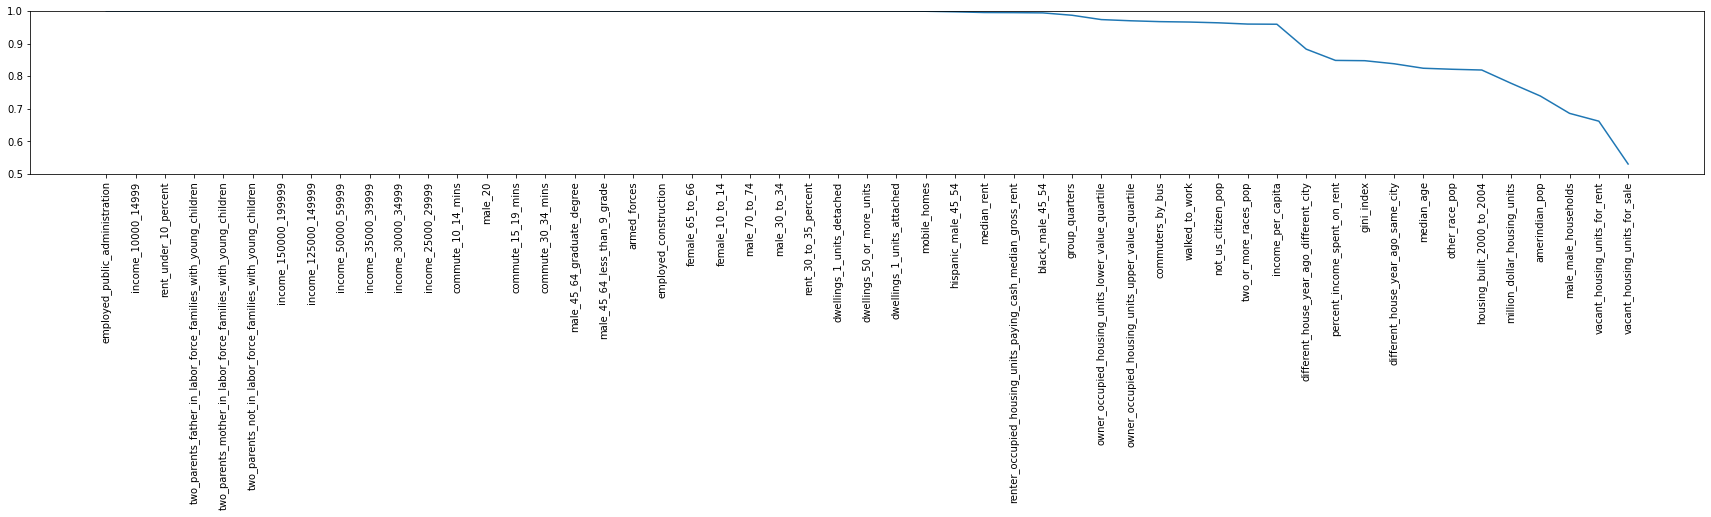

In [162]:
run_lasso_model_scaled(path, 0, 10, 11)

In [103]:
list(X.columns)

{'alpha': 1.0101010101010102}

# Prototyping work for function

In [66]:
for i in range(0,500):
    try:
        datetime.strptime(data.iloc[:,i].name, '%Y-%m')
        date_col_name = data.iloc[:,i].name
        break
    except:
        i+=1

X = data.drop([date_col_name, 'RegionName', 'City', 'State'], axis=1)
y = data[date_col_name]

In [67]:
X

,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,...,occupation_production_transportation_material,occupation_sales_office,occupation_services,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college
0,92805.0,41910.0,41890.0,50915.0,41.3,1811.0,1442.0,1812.0,848.0,823.0,...,1768.0,7237.0,5557.0,32166.0,7237.0,2694.0,3403.0,2356.0,22134.0,6152.0
1,70052.0,36624.0,35414.0,34638.0,31.2,1978.0,1151.0,1122.0,275.0,96.0,...,1525.0,10249.0,4323.0,33882.0,10249.0,1552.0,1591.0,812.0,12522.0,3196.0
2,62435.0,33693.0,27151.0,35284.0,43.3,1583.0,1029.0,993.0,408.0,471.0,...,828.0,6925.0,1922.0,25796.0,6925.0,1429.0,1782.0,1069.0,10397.0,2595.0
3,114989.0,35342.0,55688.0,59301.0,34.9,4326.0,5416.0,5466.0,3673.0,886.0,...,1980.0,9323.0,4805.0,34386.0,9323.0,9079.0,9539.0,8093.0,39508.0,5843.0
4,71308.0,33584.0,35945.0,35363.0,30.3,2157.0,1308.0,1285.0,437.0,1073.0,...,1136.0,10501.0,3125.0,32035.0,10501.0,2140.0,1853.0,1448.0,15963.0,5459.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,2059.0,1344.0,1130.0,929.0,32.2,0.0,7.0,12.0,29.0,0.0,...,35.0,315.0,84.0,1164.0,315.0,15.0,20.0,44.0,246.0,36.0
1857,7357.0,1973.0,3376.0,3981.0,21.9,298.0,212.0,318.0,207.0,292.0,...,417.0,700.0,467.0,1200.0,700.0,279.0,430.0,493.0,3385.0,1816.0
1858,2536.0,1595.0,1142.0,1394.0,45.3,31.0,24.0,26.0,32.0,10.0,...,30.0,279.0,38.0,1067.0,279.0,2.0,43.0,121.0,447.0,93.0
1859,4403.0,1485.0,2462.0,1941.0,37.6,167.0,128.0,145.0,204.0,126.0,...,334.0,343.0,331.0,515.0,343.0,201.0,225.0,327.0,1154.0,231.0


In [72]:
lasso = Lasso(normalize=True, max_iter=1000)
lasso_params = {'alpha':np.linspace(0,100,100)}
grid_lasso = GridSearchCV(lasso, lasso_params, scoring='r2', n_jobs=-1, cv=5, verbose=2)

grid_lasso.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=Lasso(normalize=True), n_jobs=-1,
             param_grid={'alpha': array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.2323...
        72.72727273,  73.73737374,  74.74747475,  75.75757576,
        76.76767677,  77.77777778,  78.78787879,  79.7979798 ,
        80.80808081,  81.81818182,  82.82828283,  83.83838384,
        84.84848485,  85.85858586,  86.86868687,  87.87878788,
        88.88888889,  89.8989899 ,  90.90909091,  91.91919192,
        92.92929293,  93.93939394,  94.94949495,  95.95959596,
        96.96969697,  97.97979798,  98.98989899, 100.        ])},
             return_train_score=True, scoring='r2', verbose=2)

In [78]:
grid_lasso.best_params_['alpha']

1.0101010101010102

In [73]:
grid_lasso.score(X,y)

0.605816069780345

In [77]:
cross_val_score(grid_lasso, X, y, scoring='r2', n_jobs=-1, cv=5)

array([0.83129275, 0.82774072, 0.85928768, 0.28358486, 0.80651477])

# Maybe go log price??

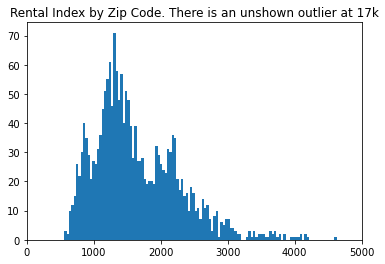

In [55]:
plt.hist(y, bins=500)
plt.xlim(0,5000)
plt.title('Rental Index by Zip Code. There is an unshown outlier at 17k')
plt.show()

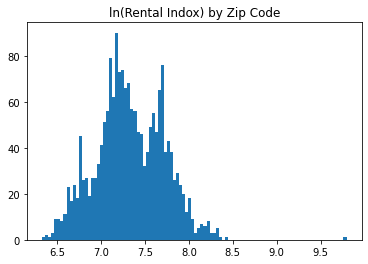

In [56]:
plt.hist(np.log(y), bins=100)
plt.title('ln(Rental Indox) by Zip Code')
plt.show()

## What is an outlier?

In [42]:
len(y[y>3500])

30

In [43]:
len(y)

1858

In [48]:
np.std(np.log(y))

0.3845720106469143

In [49]:
np.mean(np.log(y))

7.329237791578592

In [50]:
np.mean(np.log(y)) + 3*np.std(np.log(y))

8.482953823519335

In [51]:
np.exp(np.mean(np.log(y)) + 3*np.std(np.log(y)))

4831.700830689226